# Always Run

## Imports, Physical Channels, Qubit Definitions, Functions a

TODO:
 - Have a saving figure and data procedure that is never redundant and automatic based on the cells being run (import from elsewhere)
 - Have a resonator tracking and saving procedure that then is assigned to the qubit object
 - Better understand calibration specifically of RO delay
 - (Eventually) Would be nice to have a central matplotlib figure template with everything nicely configured and customized (for fun)
 - Would be nice to have an array mapping the currents on each line to each qubit to the resonator frequency rather than just one value

In [1]:
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import logging
import math as m
import statistics as stat
from typing import Callable
from qcodes.instrument_drivers.yokogawa.GS200 import GS200

import laboneq
from laboneq.simple import *
import laboneq.pulse_sheet_viewer.pulse_sheet_viewer as psv
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)

-QAOut (QACHANNELS/0/OUTPUT) - C6

-QAIn (QACHANNELS/0/INPUT)   - B4

-AWG1 (SGCHANNELS/0/OUTPUT)  - A7 - SGKP_Drive

-AWG2 (SGCHANNELS/1/OUTPUT)  - C2 - SGKP_Flux 

-AWG3 (SGCHANNELS/2/OUTPUT)  - A5 - C2PHI_Drive

-AWG4 (SGCHANNELS/3/OUTPUT)  - C3 - F1_Drive

-AWG5 (SGCHANNELS/4/OUTPUT)  - A1 - F0_Drive

-AWG6 (SGCHANNELS/5/OUTPUT)  - C1 - HGKP_Drive

-C2PHI_Flux: DC4

-F0_Flux_Pulse: A16

-HGKP_Flux_Pulse: A14

(Driving all Transmons through F0's drive since it is closest on the chip)

In [2]:
# Just be careful about the drive lines.
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH

connections:
  device_shfqc:
    - acquire_signal: T0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: T0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: T0/drive_line
      ports: SGCHANNELS/3/OUTPUT

    - acquire_signal: T1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: T1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: T1/drive_line
      ports: SGCHANNELS/3/OUTPUT

    - acquire_signal: F0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: F0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: F0/drive_line
      ports: SGCHANNELS/3/OUTPUT

    - acquire_signal: F1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: F1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: F1/drive_line
      ports: SGCHANNELS/3/OUTPUT

    - acquire_signal: C2PHI/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: C2PHI/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: C2PHI/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - acquire_signal: HGKP/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: HGKP/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: HGKP/drive_line
      ports: SGCHANNELS/5/OUTPUT

    - acquire_signal: SGKP/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: SGKP/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - iq_signal: SGKP/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: SGKP/flux_drive_line
      ports: SGCHANNELS/1/OUTPUT
"""
#the very last signal (iq_signal for flux_drive_line) needs to manually configure a LO (even if it will only be used in LF mode)

The logical signal group is what defines the set of logical parameters for measurements. This needs to get assigned to an experimental signal group in the Experiment class connecting theory with device_setup (shown later).

In [477]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc, # yaml fully describes logical signal layout
    server_host="localhost",  # ip address of the LabOne dataserver
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()}

## Qubit Parameters

In [466]:
T0 = Transmon.from_logical_signal_group(
    uid='T0',
    lsg=device_setup.logical_signal_groups['T0'],
    parameters=TransmonParameters(
        readout_resonator_frequency=6.399e9,
        readout_lo_frequency=6.4e9,
        resonance_frequency_ge=4e9,
        drive_lo_frequency=4e9,
        readout_integration_delay=88e-9,
        readout_range_out=0,
        drive_range=10,
        readout_range_in=0,
        user_defined={
            'pulse_length': 50e-9,
            'readout_len': 2.048e-6, 
            'time_domain_reset_length': 20e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': 1,
            'amplitude_pi': None,
        }
    )
)

T1 = Transmon.from_logical_signal_group(
    uid='T1',
    lsg=device_setup.logical_signal_groups['T1'],
    parameters=TransmonParameters(
        readout_resonator_frequency=6.56285e9,
        readout_lo_frequency=6.4e9,
        resonance_frequency_ge=3.565e9,
        drive_lo_frequency=3.6e9,
        readout_integration_delay=88e-9,
        readout_range_out=-5,
        drive_range=10,
        readout_range_in=10,
        user_defined={
            'pulse_length': 500e-9,
            'readout_len': 2e-6,
            'time_domain_reset_length': 300e-6,
            'cw_reset_length': 5e-9,
            'readout_amp': 0.5,
            'amplitude_pi': 0.32,
            'amplitude_pi/2': 0.18,
        }
    )
)

F0 = Transmon.from_logical_signal_group(
    uid='F0',
    lsg=device_setup.logical_signal_groups['F0'],
    parameters=TransmonParameters(
        readout_resonator_frequency=6.734e9,
        readout_lo_frequency=6.8e9,
        resonance_frequency_ge=6.6e9,
        drive_lo_frequency=6.4e9,
        readout_integration_delay=88e-9, 
        readout_range_out=-15,
        drive_range=10,
        readout_range_in=5,
        user_defined={
            'pulse_length': 500e-9,
            'readout_len': 2e-6, 
            'time_domain_reset_length': 200e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': 0.85,
            'amplitude_pi': None,
            'current_sweetspot': None,
            'current_setpoint': None,
        }
    )
)

F1 = Transmon.from_logical_signal_group(
    uid='F1',
    lsg=device_setup.logical_signal_groups['F1'],
    parameters=TransmonParameters(
        readout_resonator_frequency=6.866e9,
        readout_lo_frequency=6.8e9,
        resonance_frequency_ge=4e9, 
        drive_lo_frequency=4e9, 
        readout_integration_delay=88e-9, 
        readout_range_out=0,
        drive_range=10,
        readout_range_in=-10, 
        user_defined={
            'pulse_length': 50e-9,
            'readout_len': 2e-6, 
            'time_domain_reset_length': 40e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': None,
            'amplitude_pi': 0.7,
            'current_sweetspot': None,
            'current_setpoint': None,
        }
    )
)

C2PHI = Transmon.from_logical_signal_group(
    uid='C2PHI',
    lsg=device_setup.logical_signal_groups['C2PHI'],
    parameters=TransmonParameters(
        readout_resonator_frequency=7.1e9,
        readout_lo_frequency=7e9,
        resonance_frequency_ge=4e9,
        drive_lo_frequency=4e9,
        readout_integration_delay=88e-9,
        readout_range_out=-10,
        drive_range=0,
        readout_range_in=5,
        user_defined={
            'pulse_length': 50e-9,
            'readout_len': 2e-6, 
            'time_domain_reset_length': 200e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': None,
            'amplitude_pi': None,
            'current_sweetspot': None,
            'current_setpoint': None,
        }
    )
)

HGKP = Transmon.from_logical_signal_group(
    uid='HGKP',
    lsg=device_setup.logical_signal_groups['HGKP'],
    parameters=TransmonParameters(
        readout_resonator_frequency=7.2796e9,
        readout_lo_frequency=7.2e9,
        resonance_frequency_ge=4e9, 
        drive_lo_frequency=4e9, 
        readout_integration_delay=88e-9, 
        readout_range_out=-10,
        drive_range=0,
        readout_range_in=5,
        user_defined={
            'pulse_length': 50e-9,
            'readout_len': 2e-6,
            'time_domain_reset_length': 200e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': None,
            'amplitude_pi': None,
            'current_sweetspot': None,
            'current_setpoint': None,
        }
    )
)

SGKP = Transmon.from_logical_signal_group(
    uid='SGKP',
    lsg=device_setup.logical_signal_groups['SGKP'],
    parameters=TransmonParameters(
        readout_resonator_frequency=7.46205e9,
        readout_lo_frequency=7.4e9,
        resonance_frequency_ge=4e9, 
        drive_lo_frequency=4e9,
        readout_integration_delay=88e-9,
        readout_range_out=-25,
        drive_range=10,
        readout_range_in=5,
        user_defined={
            'pulse_length': 50e-9,
            'readout_len': 2e-6,
            'time_domain_reset_length': 200e-9,
            'cw_reset_length': 5e-9,
            'readout_amp': 0.8,
            'amplitude_pi': 1,
            'amplitude_pi/2': 1,
            'current_sweetspot': None,
            'current_setpoint': None,
        }
    )
)

qubit=F0 #Defines which qubit we are actually measuring
averages=2**12
device_setup.set_calibration(qubit.calibration()) #Uses qubit params for calib

readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp'],
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

# device_setup.get_calibration() # For checking calibration

## Defining Functions
Defining functions for plotting statistics and other useful functions

In [5]:
def plot_box_whisker_time_series(
        datetime_array: np.ndarray, float_array: np.ndarray,
        t_type_str: str, time_interval_str: str ='2min'):
    '''Plots data using box and whisker according to set time interval'''
    data = pd.DataFrame({'time': atetime_array, 'value': float_array})
    data.set_index('time', inplace=True)
    datantime = data.resample(time_interval_str).apply(list) 
    datantime.dropna(inplace=True)
    time_labels = datantime.index
    float_data_per_interval = datantime['value']
    plt.figure(figsize=(16, 6))
    plt.boxplot(
        float_data_per_interval, 
        positions=range(len(time_labels)), 
        widths=0.7)
    plt.xticks(
        ticks=range(len(time_labels)), 
        labels=time_labels.strftime('%H:%M'), 
        rotation=45)
    plt.xlabel('Time (Intervals)')
    plt.ylabel(f'{t_type_str} (us)')
    plt.title(f'{t_type_str} Times over Time')
    plt.tight_layout()
    plt.show()

def measure_data_stats(T_run: Callable, n_runs: int):
    '''Outputs statistics on data gathered'''
    global datetime_array #global so if the func stalls, it will still be there
    global fit_out #global so if the func stalls, it will still be there
    fit_out = np.empty((2, n_runs))
    datetime_array = np.empty((n_runs), dtype=datetime.datetime)
    for i in range(n_runs):
        fits = T_run()
        datetime_array[i] = datetime.datetime.now()
        fit_out[:,i] = fits 
    return [datetime_array, fit_out]

def stat_out(data: np.ndarray, t_type_str: str):
    mean = np.nanmean(data)
    std = np.nanstd(data)
    print(t_type_str, ' = ', str(mean), '+/-', str(std))
    return [mean, std]

def adjust_phase(
        IQ_data: np.ndarray, frequency: np.ndarray, 
        electrical_delay: float,
        ) -> np.ndarray:
    adjusted_complex = np.exp(1j*electrical_delay*2*np.pi*frequency)*IQ_data
    flattened_angle = np.unwrap(np.angle(adjusted_complex))
    flattened_angle = flattened_angle - np.mean(flattened_angle)
    return flattened_angle 

def data_directory_update():
    '''Updates data directory to today's date'''
    date = datetime.date.today()
    datadir = Path('data/' + str(date) + '/')
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    return datadir
    
datadir = data_directory_update() # might as well instantly update for notebook

def non_redund_save_fig(fig, name):
    '''A function to prevent figure overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        fig_name = Path(str(datadir) + f'/{name}_{i}.png')
        if os.path.isfile(fig_name) is False:
            fig_name = Path(str(datadir) + f'/{name}_{i}')
            fig.savefig(fig_name)
            break
        else:
            i = i+1

def non_redund_save_pd(pd_data, name):
    '''A function to prevent pd overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(pd_name) is False:
            pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
            pd_data.to_csv(pd_name)
            break
        else:
            i += 1

def non_redund_save_csv(csv_data, name):
    '''A function to prevent csv overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(csv_name) is False:
            csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
            csv_data.to_csv(csv_name)
            break
        else:
            i += 1

'''
Real time calls: Seems as if the QCoDes intruments cannot be pickled into
the experiment when it is sent to the HFSQC. To get around this, do not pass
the QCoDes object as a parameter to the call. Just have that name be in the 
global namespace which makes sure it is handled by the computer.
'''
def change_dc_current(session, new_current, step_time):
    dc.ramp_current(new_current, 10e-6, step_time)
    # print("DC Current " + str(new_current))

def change_coil_current(session, new_current, step_time):
    coil.ramp_current(new_current, 1e-6, step_time)
    print("Current coil current: " + str(new_current))
    
def sweep_progress(session, linearsweepparameter):
    print(str(linearsweepparameter.count))

# Yoko Connection
(Sometimes tempramental, so don't always run)

In [471]:
try:
    dc = GS200('yoko_right', address = 'TCPIP0::192.168.4.157::inst0::INSTR')
except Exception as e:
    print(e)

try:
    coil= GS200('yoko_left', address = 'TCPIP0::192.168.4.208::inst0::INSTR')
except Exception as e:
    print(e)

Connected to: YOKOGAWA GS210 (serial:91S621541, firmware:2.02) in 0.05s
Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.02s


In [472]:
# dc.BNC_out.set('ready') # sets low signal signature after move is completed
# dc.BNC_out.get()
# dc.ramp_current(0e-3, 1e-6,0.02)
# dc.output('off')
# dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0.02)
dc.output('on')
dc.current_range(0.01)

# coil.BNC_out.set('ready') # sets low signal signature after move is completed
# coil.BNC_out.get()
# coil.ramp_current(0e-3, 1e-6,0.02)
# coil.output('off')
# coil.source_mode('CURR')
coil.ramp_current(0e-3, 1e-6,0.02)
coil.output('on')
coil.current_range(0.01)

# dc.current.get()
# coil.current.get()

# Readout Delay Calibration

In [47]:
readout_delay = LinearSweepParameter(
    uid='readout_delay', start=75e-9, stop=125e-9, count=51)

exp = Experiment(
    uid="Readout_Delay_Calibration",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
    ]
)
exp_calibration = Calibration()
with exp.sweep(uid="readout_delay", parameter=readout_delay,):
    exp_calibration['acquire'] = SignalCalibration(port_delay=readout_delay)
    exp.set_calibration(exp_calibration)
    with exp.acquire_loop_rt(
        uid="shots",
        count=averages,
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # readout pulse and data acquisition
        with exp.section(uid="readout",):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire(
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse # What is actually integrated against
            )
        with exp.section(uid="delay_between_readout", length=210e-9):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")

## Compile Session
Do final checks before running the job.

In [48]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

## Run session

In [49]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [ ]:
time_delay = my_acquired_results.axis[0]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = adjust_phase(IQ_data, freqs, qubit.parameters.readout_integration_delay)

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(time_delay*1e9, amplitude)
ax[0].set_title(f'{qubit.uid} Sweeping Acquire Delay')
ax[0].set_xlabel('Time delay (ns)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].vlines(87, np.min(amplitude), np.max(amplitude), 'r')
ax[0].grid()

ax[1].plot(time_delay*1e9, phase)
ax[1].set_title(f'{qubit.uid} Sweeping Acquire Delay')
ax[1].set_xlabel('Time delay (ns)')
ax[1].set_ylabel('Phase')
ax[1].vlines(87, np.min(phase), np.max(phase))
ax[1].grid()
fig.tight_layout()

# Global Resonator Trace

## Experiment

In [268]:
#--- Defining Parameter Sweeps ---
readout_lo_freq_sweep = LinearSweepParameter(
    uid='Readout_LO',
    start=4e9,
    stop=8e9,
    count=5)
readout_freq_sweep = LinearSweepParameter(
    uid='Readout_Frequency',
    start=-500e6,
    stop=495e6,
    count=101)

#--- Signal Mappings ---
exp_signals = [
    ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
    ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),]

#--- Defining Sections and Sweeps and Experiment ---
exp = Experiment(
    uid='Global Resonator Trace',
    signals=exp_signals,)
RO_LO_Sweep = Sweep(
    uid='Readout LO Frequency Sweep',
    parameters=readout_lo_freq_sweep)
RT_Loop = AcquireLoopRt(
    uid='Shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.SPECTROSCOPY,)
AWG_Freq_Sweep = Sweep(
    uid='Readout Frequency Sweep',
    parameters=readout_freq_sweep,
    reset_oscillator_phase=False)
Meas_Acquire = Section(uid='Pulsed Single Frequency Readout')
Meas_Acquire.play(
    signal='measure',
    pulse=readout_pulse)
Meas_Acquire.acquire(
    signal='acquire', 
    handle='single_freq_data', 
    length=qubit.parameters.user_defined['readout_len'])
Delay_After_Count = Section(uid='Delay Between Readout')

#--- Properly Defining Nesting Order ---
exp.add(RO_LO_Sweep)
RO_LO_Sweep.add(RT_Loop)
RT_Loop.add(AWG_Freq_Sweep)
AWG_Freq_Sweep.add(Meas_Acquire)
AWG_Freq_Sweep.add(Delay_After_Count)
Delay_After_Count.reserve(signal='measure')
Delay_After_Count.reserve(signal='acquire')

#--- Calibrating Experiment ---
readout_osc = Oscillator(
    "readout_osc",
    frequency=readout_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
readout_lo = Oscillator(
    "readout_lo",
    frequency=readout_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)

exp_calibration = Calibration()
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    local_oscillator=readout_lo)
exp.set_calibration(exp_calibration)

#--- Compiling Session ---
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

#--- Running Session ---
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

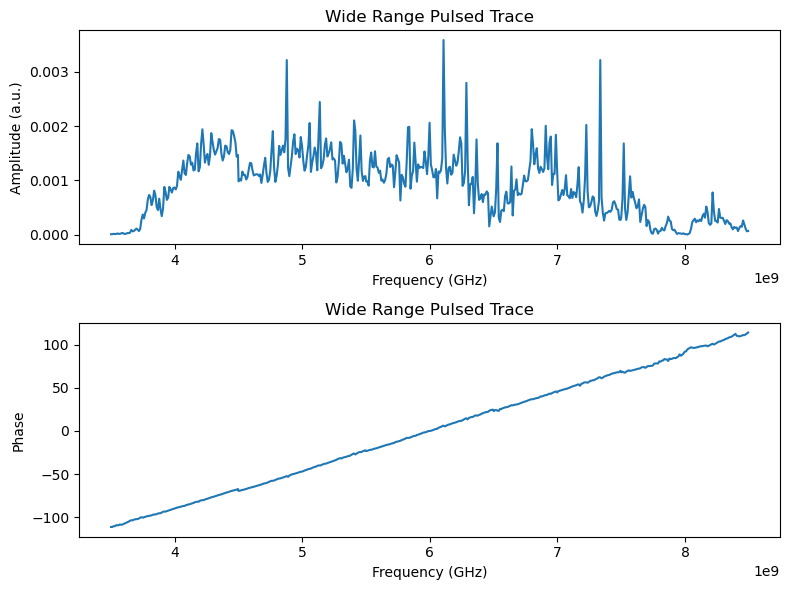

In [269]:
# Extracting useful data
lo_array = my_acquired_results.axis[0]
AWG_freqs = my_acquired_results.axis[1]
freqs = np.empty((0))
for lo in lo_array:
    freqs = np.append(freqs, lo + AWG_freqs,)

# 
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = adjust_phase(IQ_data, freqs, qubit.parameters.readout_integration_delay)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title('Wide Range Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[1].plot(freqs, phase)
ax[1].set_title('Wide Range Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
fig.tight_layout()

# Local Resonator Trace
- Actually just works to put in the frequency values for start and stop.
The LO will adjust as necessary on the backend. Nice.

In [473]:
qubit.parameters.readout_frequency

-66000000.0

In [474]:
ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=qubit.parameters.readout_frequency-5e6,
    stop=qubit.parameters.readout_frequency+5e6,
    count=201)

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(
        uid='Readout Frequency Sweep',
        parameter=ro_frequency_sweep,
        reset_oscillator_phase=False
    ):
        with exp.section(uid="Pulsed Single Frequency Readout"):
            exp.play(
                signal="measure",
                pulse=readout_pulse
            )
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['cw_reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE,)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    port_delay=qubit.parameters.readout_integration_delay)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [475]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

## Plot and Analyze Data

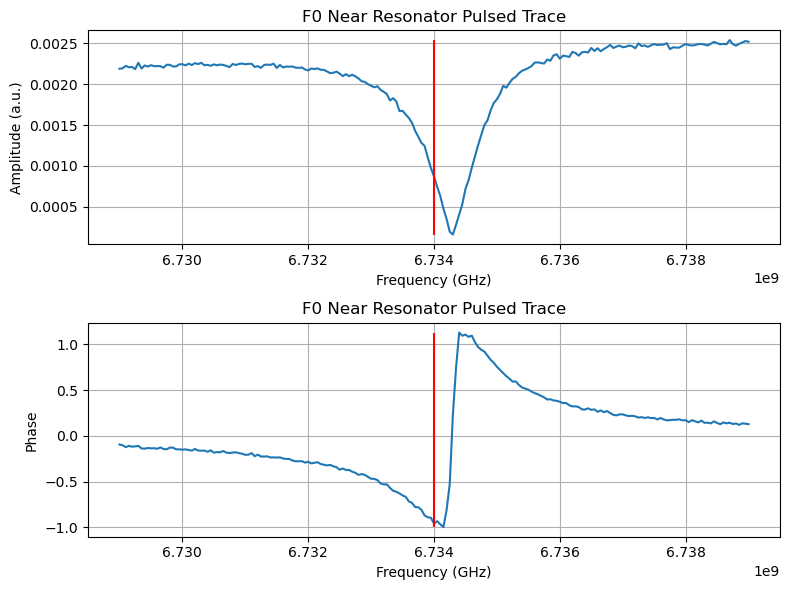

In [476]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.readout_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = adjust_phase(IQ_data, freqs, qubit.parameters.readout_integration_delay)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Near Resonator Pulsed Trace')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].grid()
ax[1].plot(freqs, phase)
ax[1].set_title(f'{qubit.uid} Near Resonator Pulsed Trace')
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()
ax[0].vlines(qubit.parameters.readout_resonator_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].vlines(qubit.parameters.readout_resonator_frequency, np.min(phase), np.max(phase), colors='r');

# Punchout
This works, but the power sweep is NEAR_TIME. Putting it in the REAL_TIME section makes the play channel seem like there are multiple envelopes for the readout pulse? Might be becasue of some timing or alignement issue... For now it seems fine given that the loop only needs to be executed a handful of times.

In [399]:
#Note this is a power sweep of the pulse amplitude, not of powers! The conversion from amplitude to powers is squared.
readout_pulse_punchout = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=1,
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=qubit.parameters.readout_frequency-3e6,
    stop=qubit.parameters.readout_frequency+3e6,
    count=201) 

power_sweep = SweepParameter(
    uid='Readout_Power',
    values=np.logspace(start=-1.5,stop=0,num=15,base=10))

exp = Experiment(
    uid="Punchout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
    ]
)

with exp.sweep(
    uid='Power sweep',
    parameter=power_sweep,
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
    
        with exp.sweep(
            uid='Readout_Frequency_Sweep',
            parameter=ro_frequency_sweep,
            reset_oscillator_phase=False
        ):
            with exp.section(uid="single_res_point_readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse_punchout,
                    amplitude=power_sweep,
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['cw_reset_length']):
                exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    port_delay=qubit.parameters.readout_integration_delay)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [400]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [401]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

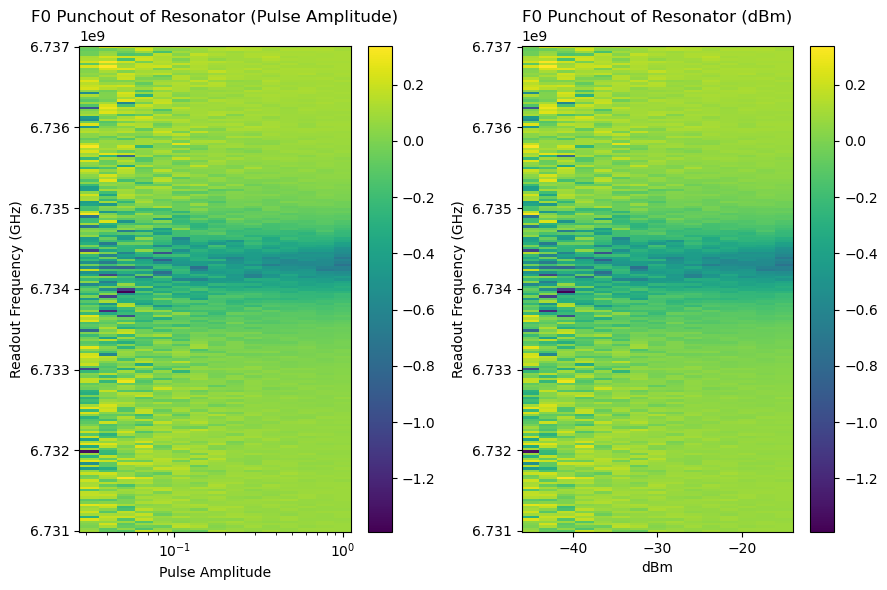

In [402]:
# For plotting punchout
freqs = my_acquired_results.axis[1]+qubit.parameters.readout_lo_frequency
IQ_data = my_acquired_results.data
normalized_amp_data = np.divide(np.abs(IQ_data).T, np.mean(np.abs(IQ_data), axis=1))
normalized_dB_data = np.log10(normalized_amp_data)
phase = adjust_phase(IQ_data, freqs, qubit.parameters.readout_integration_delay)

amplitude = my_acquired_results.axis[0]
power = 10*np.log10(amplitude**2)+qubit.parameters.readout_range_out

graphing_data = normalized_dB_data #phase.T

fig, ax = plt.subplots(1,2, figsize=(9,6))
cmap0 = ax[0].pcolor(amplitude,
             freqs,
             graphing_data,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Punchout of Resonator (Pulse Amplitude)')
ax[0].set_xlabel('Pulse Amplitude')
ax[0].set_ylabel('Readout Frequency (GHz)')
ax[0].set_xscale('log')
cmap1 = ax[1].pcolor(power,
             freqs,
             graphing_data,
             shading='nearest')
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
ax[1].set_title(f'{qubit.uid} Punchout of Resonator (dBm)')
ax[1].set_xlabel('dBm')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# Resonator 1D Flux Sweep

In [685]:
dc_sweep_param = LinearSweepParameter(
    uid='DC Current',
    start=0e-6,
    stop=4e-6,
    count=5)
coil_sweep_param = LinearSweepParameter(
    uid='Coil Current',
    start=-100e-6,
    stop=100e-6,
    count=101)

In [127]:
# This one is a direct copy of my working spectroscopy scan but now includes a 1D resonator sweep.
lo_freq_offset = qubit.parameters.readout_resonator_frequency-qubit.parameters.readout_lo_frequency

ro_frequency_sweep = LinearSweepParameter(
    uid='Readout_Frequency_Sweep',
    start=lo_freq_offset-12e6,
    stop=lo_freq_offset+12e6,
    count=101) #NOTE! This is the frequency offset from the LO. Need better integration for ease of use.

dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=-500e-6, stop=500e-6, count=201)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-100e-6, stop=100e-6, count=101)

current_sweep_param = dc_sweep_param #Simply change coil_sweep_param to dc_sweep param for dc sweep.

exp = Experiment(
    uid="1D Current vs Resonator",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid="Yoko Sweep",
    parameter=current_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('change_current', new_current=current_sweep_param, step_time=0.01) 
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
                uid='Readout Resonator Frequency Sweep',
                parameter=ro_frequency_sweep,
                reset_oscillator_phase=True
            ):
                with exp.section(uid="Pulsed Single Frequency Readout"):
                    exp.play(
                        signal="measure",
                        pulse=readout_pulse
                    )
                    exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                        signal='acquire',
                        handle='single_freq_data',
                        length=qubit.parameters.user_defined['readout_len'],
                    )
                with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                    exp.reserve(signal="measure")

exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc,
    port_delay=qubit.parameters.readout_integration_delay)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [387]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'change_current')
session.register_neartime_callback(change_coil_current, 'change_current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=10000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [388]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

Current coil current: -0.0005
Current coil current: -0.000495
Current coil current: -0.00049
Current coil current: -0.000485
Current coil current: -0.00048
Current coil current: -0.000475
Current coil current: -0.00047
Current coil current: -0.000465
Current coil current: -0.00046
Current coil current: -0.000455
Current coil current: -0.00045
Current coil current: -0.00044500000000000003
Current coil current: -0.00044
Current coil current: -0.000435
Current coil current: -0.00043
Current coil current: -0.00042500000000000003
Current coil current: -0.00042
Current coil current: -0.000415
Current coil current: -0.00041
Current coil current: -0.000405
Current coil current: -0.0004
Current coil current: -0.000395
Current coil current: -0.00039
Current coil current: -0.00038500000000000003
Current coil current: -0.00038
Current coil current: -0.000375
Current coil current: -0.00037
Current coil current: -0.000365
Current coil current: -0.00035999999999999997
Current coil current: -0.000355


## Plot and Analyze Data

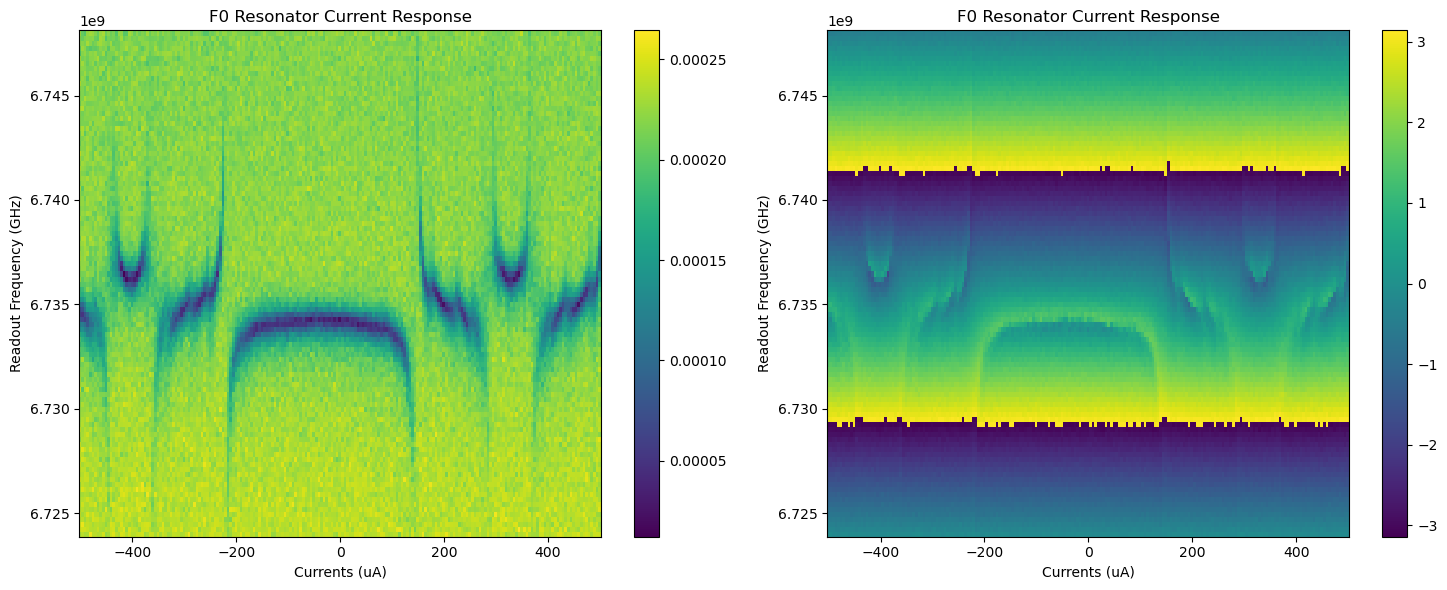

In [389]:
# For plotting 1D flux sweep
freqs = my_acquired_results.axis[1] + qubit.parameters.readout_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = adjust_phase(IQ_data, freqs, qubit.parameters.readout_integration_delay)
currents = my_acquired_results.axis[0]*1e6

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(currents,
             freqs,
             amplitude.T,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator Current Response')
ax[0].set_xlabel('Currents (uA)')
ax[0].set_ylabel('Readout Frequency (GHz)')
cmap1 = ax[1].pcolor(currents,
             freqs,
             phase.T,
             shading='nearest',)
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
ax[1].set_title(f'{qubit.uid} Resonator Current Response')
ax[1].set_xlabel('Currents (uA)')
ax[1].set_ylabel('Readout Frequency (GHz)')
fig.tight_layout()

# Resonator 2D Flux Sweep
- Would be nice to have a faster flux sweep functionality at the end (or beginning?) of each loop

In [336]:
dc_sweep_param = LinearSweepParameter(
    uid='DC_Current', start=-2000e-6, stop=2000e-6, count=301)

coil_sweep_param = LinearSweepParameter(
    uid='Coil_Current', start=-150e-6, stop=150e-6, count=301)

exp = Experiment(
    uid="2D Current Sweep",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='coil sweep',
    parameter=coil_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('Coil_Current', new_current=coil_sweep_param, step_time=0.01)
    with exp.sweep(
        uid="dc sweep",
        parameter=dc_sweep_param,
        execution_type=ExecutionType.NEAR_TIME,
    ):
        exp.call('DC_Current', new_current=dc_sweep_param, step_time=0.01) #note that "argument" session (first argument to the function) is automatically passed
        with exp.acquire_loop_rt(
            uid="shots",
            count=averages,
            acquisition_type=AcquisitionType.INTEGRATION,
            averaging_mode=AveragingMode.SEQUENTIAL
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    kernel=readout_pulse,
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

## Compile Session
Do final checks before running the job.

In [337]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'DC_Current')
session.register_neartime_callback(change_coil_current, 'Coil_Current')
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=1000,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [338]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

Current coil current: -0.00015
Current coil current: -0.000149
Current coil current: -0.000148
Current coil current: -0.000147
Current coil current: -0.000146
Current coil current: -0.000145
Current coil current: -0.00014399999999999998
Current coil current: -0.00014299999999999998
Current coil current: -0.00014199999999999998
Current coil current: -0.00014099999999999998
Current coil current: -0.00014
Current coil current: -0.000139
Current coil current: -0.000138
Current coil current: -0.000137
Current coil current: -0.000136
Current coil current: -0.00013499999999999997
Current coil current: -0.00013399999999999998
Current coil current: -0.00013299999999999998
Current coil current: -0.00013199999999999998
Current coil current: -0.00013099999999999999
Current coil current: -0.00013
Current coil current: -0.000129
Current coil current: -0.000128
Current coil current: -0.000127
Current coil current: -0.00012599999999999997
Current coil current: -0.000125
Current coil current: -0.000123

## Plot and Analyze Data
TODO: Properly Plot

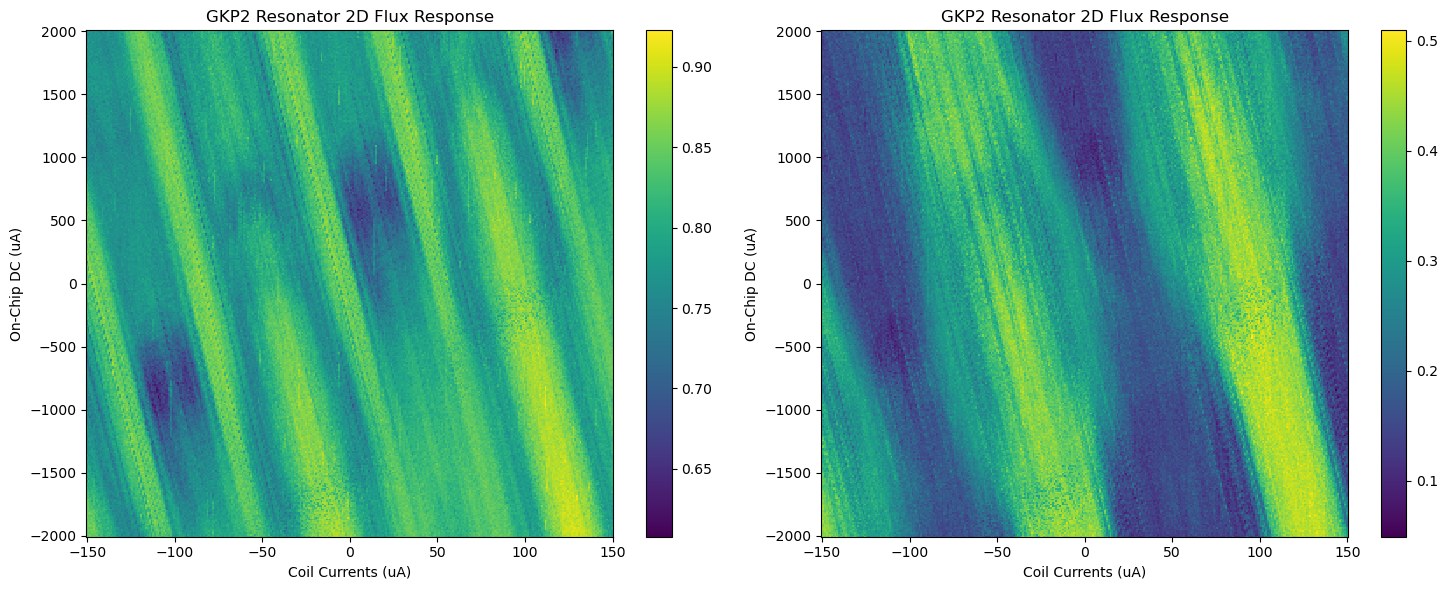

In [341]:
#plotting resonator over flux
amp_data = np.abs(my_acquired_results.data)
phase_data = np.angle(my_acquired_results.data)
db_data = np.log10(amp_data)

coil_currents = my_acquired_results.axis[0]
dc_currents = my_acquired_results.axis[1]

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(coil_currents*1e6,
             dc_currents*1e6,
             db_data.T,
             shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator 2D Flux Response')
ax[0].set_xlabel('Coil Currents (uA)')
ax[0].set_ylabel('On-Chip DC (uA)')
cmap1 = ax[1].pcolor(coil_currents*1e6,
             dc_currents*1e6,
             phase_data.T,
             shading='nearest')
ax[1].set_title(f'{qubit.uid} Resonator 2D Flux Response')
ax[1].set_xlabel('Coil Currents (uA)')
ax[1].set_ylabel('On-Chip DC (uA)')
fig.colorbar(cmap0, ax=ax[0])
fig.colorbar(cmap1, ax=ax[1])
fig.tight_layout()

# Global Qubit Spectroscopy
-Unclear still how to have the LO naturally move during the sweep. Maybe build it into a function call?
-For some reason, the drive frequency sweep is upset that it is in real-time. Need to investigate further.

In [407]:
drive_lo_freq_sweep = LinearSweepParameter(
    uid='Drive_LO', start=1e9, stop=8e9, count=8)

drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency', start=-500e6, stop=498e6, count=500)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Sweep Drive LO',
    parameter=drive_lo_freq_sweep
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Drive Frequency Sweep',
            parameter=drive_freq_sweep,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                    uid=f"drive_pulse_{qubit.uid}",
                    length=600e-9,
                    width=500e-9*0.9,
                    sigma=0.2,
                    marker = {"marker1": {"enable": True}}))
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']*50):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_lo = Oscillator(
    'drive_lo',
    frequency=drive_lo_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    local_oscillator=drive_lo)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [408]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [409]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

In [410]:
drive_lo_array = my_acquired_results.axis[0]
drive_AWG_freqs = my_acquired_results.axis[1]
drive_freqs = np.empty((0))
for drive_lo in drive_lo_array:
    drive_freqs = np.append(drive_freqs, drive_lo + drive_AWG_freqs,)

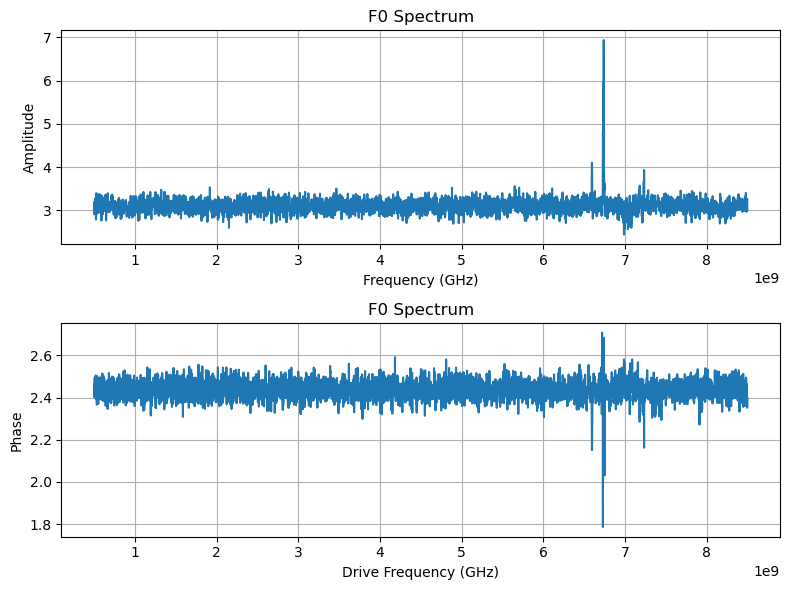

In [411]:
# For plotting current vs single resonator point
IQ_data = my_acquired_results.data.ravel()
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
# ax[0].set_ylim(0.05,0.25)
ax[0].grid()
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()

# Local Qubit Spectroscopy 

In [442]:
qubit.parameters.drive_frequency_ge

0.0

In [462]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency',
    start=qubit.parameters.drive_frequency_ge-100e6,
    stop=qubit.parameters.drive_frequency_ge+100e6,
    count=201
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=1), #qubit.parameters.user_defined['amplitude_pi']), #max power to start
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [463]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [464]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

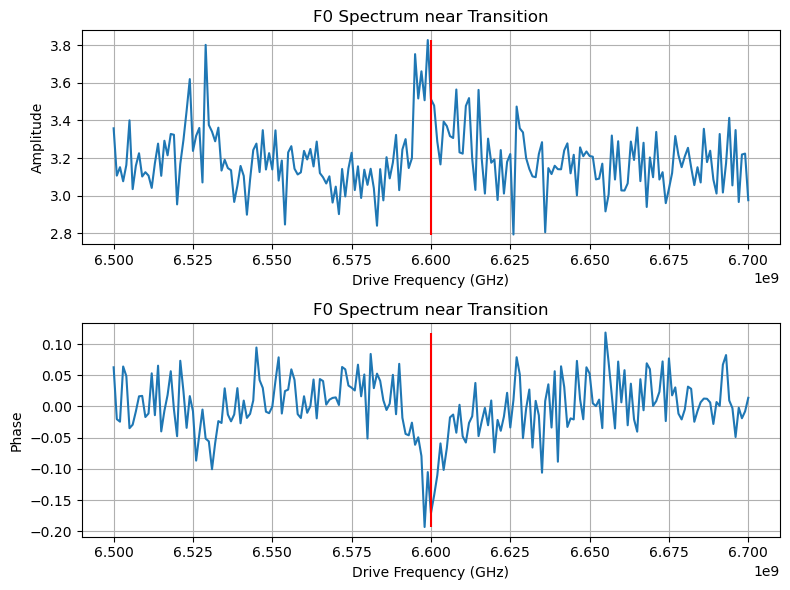

In [465]:
# For plotting current vs single resonator point
freqs = my_acquired_results.axis[0] + qubit.parameters.drive_lo_frequency
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)
phase = phase - np.mean(phase)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum near Transition')
ax[0].set_xlabel('Drive Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
# ax[0].vlines(qubit.parameters.drive_frequency_ge+qubit.parameters.drive_lo_frequency, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].plot(freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum near Transition')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
ax[0].vlines(qubit.parameters.resonance_frequency_ge, np.min(amplitude), np.max(amplitude), colors='r');
ax[1].vlines(qubit.parameters.resonance_frequency_ge, np.min(phase), np.max(phase), colors='r')
fig.tight_layout()

# LF Qubit Spectroscopy
<1GHz drive frequency

In [413]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive_Frequency',
    start=10e6,
    stop=1e9,
    count=991
)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"],
                    amplitude=1), #qubit.parameters.user_defined['amplitude_pi']), #max power to start
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

exp_calibration = Calibration()
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["drive"] = SignalCalibration(
    oscillator=drive_osc,
    port_mode=PortMode.LF)
exp.set_calibration(exp_calibration)

## Compile Session
Do final checks before running the job.

In [414]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [415]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

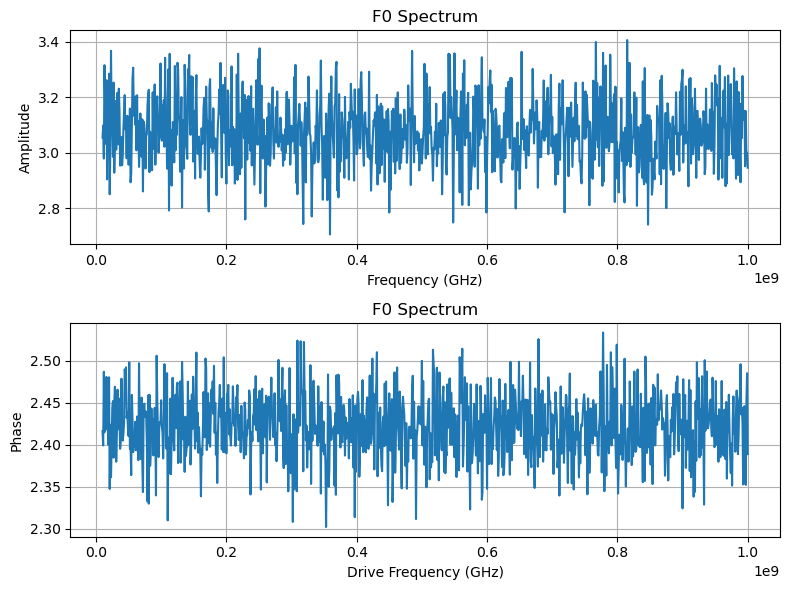

In [416]:
# For plotting current vs single resonator point
drive_freqs = my_acquired_results.axis[0]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].plot(drive_freqs, amplitude)
ax[0].set_title(f'{qubit.uid} Spectrum')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid()
ax[1].plot(drive_freqs, phase)
ax[1].set_title(f'{qubit.uid} Spectrum')
ax[1].set_xlabel('Drive Frequency (GHz)')
ax[1].set_ylabel('Phase')
ax[1].grid()
fig.tight_layout()

# X-Gate Amplitude Tuneup
Rabi Amplitude Sweep

In [7]:
rabi_amp_sweep = LinearSweepParameter(
    uid='rabi_amplitude', start=0, stop=1, count=51)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Amplitude Sweep',
        parameter=rabi_amp_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                    uid=f"drive_spec_pulse_{qubit.uid}",
                    length=qubit.parameters.user_defined["pulse_length"], #can have this be longer if not enough periods
                    amplitude=1,), #max power to start
                amplitude=rabi_amp_sweep,
            )
        with exp.section(
            uid="single_res_point_readout",
            play_after='Play drive',
        ):
            exp.play(
                signal="measure",
                pulse=readout_pulse)
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
            exp.reserve(signal="measure")
            exp.reserve(signal="drive")

## Compile Session
Do final checks before running the job.

In [8]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [9]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters (phase): [10.0077153  -0.03912846  0.35527871  0.01609086]


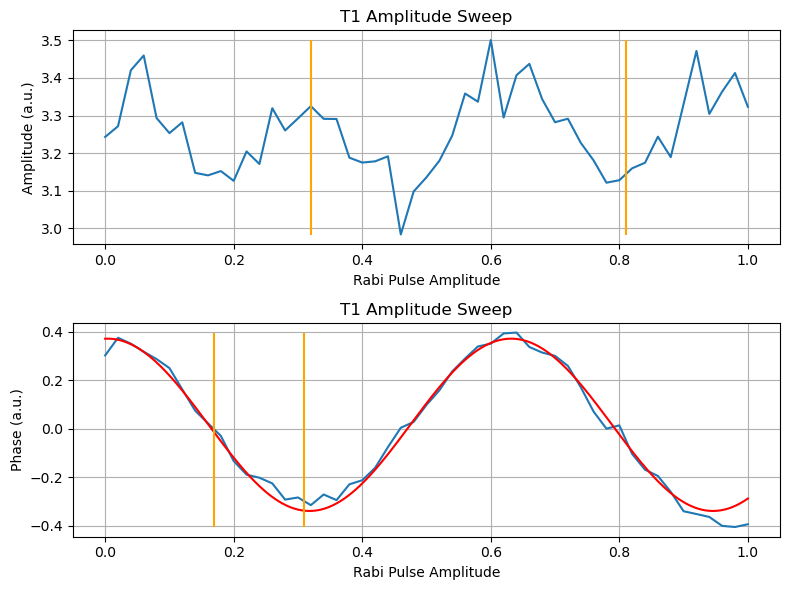

In [10]:
# plot measurement data
drive_amp = my_acquired_results.axis[0]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.unwrap(np.angle(IQ_data))
phase = phase-np.mean(phase)

fitting_plot_x = np.linspace(rabi_amp_sweep.start, rabi_amp_sweep.stop, 501)

try: popt_amp, pcov_amp = oscillatory.fit(drive_amp, amplitude)
except: pass

try: popt_phase, pcov_phase = oscillatory.fit(drive_amp, phase, 10, 0, 0.5, 0) #frequency, phase, amplitude, offset
except: pass

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(drive_amp, amplitude)
try: ax[0].plot(fitting_plot_x, oscillatory(fitting_plot_x, *popt_amp), '-r')
except: pass
ax[0].set_title(f'{qubit.uid} Amplitude Sweep')
ax[0].set_xlabel('Rabi Pulse Amplitude')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].vlines(0.81, ymin=np.min(amplitude), ymax=np.max(amplitude), color='orange')
ax[0].vlines(0.32, ymin=np.min(amplitude), ymax=np.max(amplitude), color='orange')
ax[0].grid()
ax[1].plot(drive_amp, phase)
try: ax[1].plot(fitting_plot_x, oscillatory(fitting_plot_x, *popt_phase), '-r')
except: pass
ax[1].set_title(f'{qubit.uid} Amplitude Sweep')
ax[1].set_xlabel('Rabi Pulse Amplitude')
ax[1].set_ylabel('Phase (a.u.)')
ax[1].vlines(qubit.parameters.user_defined['amplitude_pi']-0.01, ymin=np.min(phase), ymax=np.max(phase), color='orange')
ax[1].vlines(qubit.parameters.user_defined['amplitude_pi/2']-0.01, ymin=np.min(phase), ymax=np.max(phase), color='orange')
ax[1].grid()
fig.tight_layout()
try: print(f"Fitted parameters (amplitude): {popt_amp}")
except: pass
try: print(f"Fitted parameters (phase): {popt_phase}")
except: pass

# Amplitude Chevron 
(Amplitude and Pulse Length Sweeps)

In [467]:
#--- Defining Pulse Shapes ---
readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp'],
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)
drive_pulse_shape = pulse_library.gaussian_square(
    uid='Gaussian Square Pulse',
    length=1000e-9,
    amplitude=1)

#--- Defining Parameter Sweeps ---- 
drive_amp_sweep = SweepParameter(
    uid='Drive_Amp_Sweep',
    values=np.linspace(start=0, stop=1, num=11,))
drive_pulse_length_sweep = LinearSweepParameter(
    uid='Drive_Pulse_Time_Sweep',
    start=100e-9,
    stop=1100e-9,
    count=11)

#--- Signal Mappings ---
exp_signals = [
    ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
    ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
    ExperimentSignal(uid='drive', map_to=lsg[qubit.uid]['drive_line'])]

#--- Defining Sections and Sweeps and Experiment ---
exp = Experiment(
    uid='Drive Chevron',
    signals=exp_signals,)

Drive_Amp_Sweep = Sweep(
    uid='Drive Amplitude Sweep',
    parameters=drive_amp_sweep)
Drive_Pulse_Length_Sweep = Sweep(
    uid='Drive Pulse Length Sweep',
    parameters=drive_pulse_length_sweep)

RT_Loop = AcquireLoopRt(
    uid='Shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,)

Drive = Section(uid='Driving Section')
Drive.play(
    signal='drive',
    pulse=drive_pulse_shape,
    length=drive_pulse_length_sweep,
    amplitude=drive_amp_sweep)

Meas_Acquire = Section(
    uid='Pulsed Single Frequency Readout',
    play_after=Drive)
Meas_Acquire.play(
    signal='measure',
    pulse=readout_pulse,)
Meas_Acquire.acquire(
    signal='acquire', 
    handle='RO_data', 
    length=qubit.parameters.user_defined['readout_len'])

Delay_After_Count = Section(
    uid='Delay Between Readout',
    length=qubit.parameters.user_defined['time_domain_reset_length'],
    play_after=Meas_Acquire)

#--- Properly Defining Nesting Order ---
Outer_Sweep = Drive_Pulse_Length_Sweep
Inner_Sweep = Drive_Amp_Sweep
Outer_Sweep.execution_type = ExecutionType.NEAR_TIME
Inner_Sweep.execution_type = ExecutionType.REAL_TIME

exp.add(Outer_Sweep)
Outer_Sweep.add(RT_Loop)
RT_Loop.add(Inner_Sweep)
Inner_Sweep.add(Drive)
Inner_Sweep.add(Meas_Acquire)
Inner_Sweep.add(Delay_After_Count)

#--- Compile Session ---
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

#--- Run Session ---
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['RO_data']

## Plot and Analyze Data

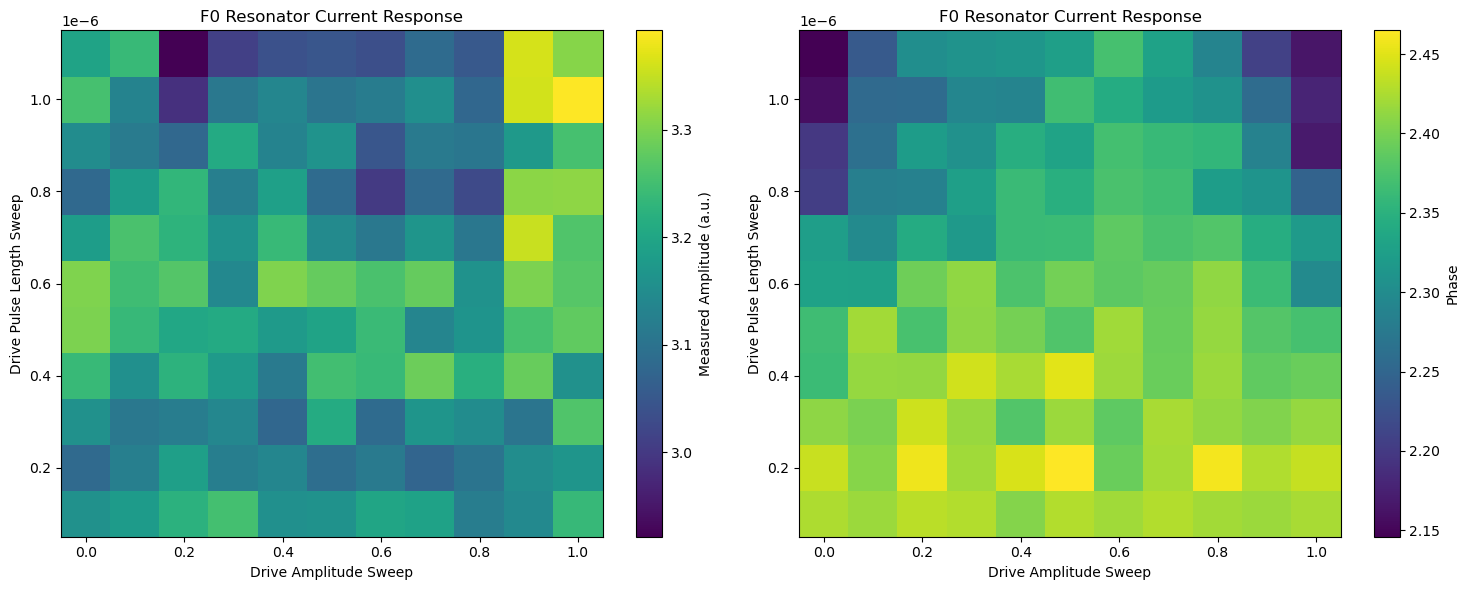

In [468]:
outer_sweep_param = my_acquired_results.axis[0]
inner_sweep_param = my_acquired_results.axis[1]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(inner_sweep_param,
    outer_sweep_param,
    amplitude,
    shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator Current Response')
ax[0].set_xlabel(f'{Inner_Sweep.uid}')
ax[0].set_ylabel(f'{Outer_Sweep.uid}')
cmap1 = ax[1].pcolor(inner_sweep_param,
    outer_sweep_param,
    phase,
    shading='nearest',)
cbar0 = fig.colorbar(cmap0, ax=ax[0],)
cbar1 = fig.colorbar(cmap1, ax=ax[1])
cbar0.set_label('Measured Amplitude (a.u.)')
cbar1.set_label('Phase')
ax[1].set_title(f'{qubit.uid} Resonator Current Response')
ax[1].set_xlabel(f'{Inner_Sweep.uid}')
ax[1].set_ylabel(f'{Outer_Sweep.uid}')
fig.tight_layout()

# Detuning Chevron
(Pulse Length and Drive Frequency Sweeps)

## Experiment

In [469]:
#--- Defining Pulse Shapes ---
readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp'],
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)
drive_pulse_shape = pulse_library.gaussian_square(
    uid='Gaussian Square Pulse',
    length=1000e-9,
    amplitude=1)

#--- Defining Parameter Sweeps ---- 
drive_freq_sweep = LinearSweepParameter(
    uid='drive_freq_sweep',
    start=qubit.parameters.drive_frequency_ge-10e6,
    stop=qubit.parameters.drive_frequency_ge+10e6,
    count=101)
drive_pulse_length_sweep = LinearSweepParameter(
    uid='drive_pulse_time_sweep',
    start=100e-9,
    stop=1600e-9,
    count=101)

#--- Signal Mappings ---
exp_signals = [
    ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
    ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
    ExperimentSignal(uid='drive', map_to=lsg[qubit.uid]['drive_line'])]

#--- Defining Sections and Sweeps and Experiment ---
exp = Experiment(
    uid='Drive Chevron',
    signals=exp_signals,)

Drive_Freq_Sweep = Sweep(
    uid='Drive Frequency Sweep',
    parameters=drive_freq_sweep)
Drive_Pulse_Length_Sweep = Sweep(
    uid='Drive Pulse Length Sweep',
    parameters=drive_pulse_length_sweep)

RT_Loop = AcquireLoopRt(
    uid='Shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,)

Drive = Section(uid='Driving Section')
Drive.play(
    signal='drive',
    pulse=drive_pulse_shape,
    length=drive_pulse_length_sweep,
    amplitude=1)

Meas_Acquire = Section(
    uid='Pulsed Single Frequency Readout',
    play_after=Drive)
Meas_Acquire.play(
    signal='measure',
    pulse=readout_pulse,)
Meas_Acquire.acquire(
    signal='acquire', 
    handle='RO_data', 
    length=qubit.parameters.user_defined['readout_len'])

Delay_After_Count = Section(
    uid='Delay Between Readout',
    length=qubit.parameters.user_defined['time_domain_reset_length'],
    play_after=Meas_Acquire)

#--- Properly Defining Nesting Order ---
Outer_Sweep = Drive_Pulse_Length_Sweep
Inner_Sweep = Drive_Freq_Sweep
Outer_Sweep.execution_type = ExecutionType.NEAR_TIME
Inner_Sweep.execution_type = ExecutionType.REAL_TIME

exp.add(Outer_Sweep)
Outer_Sweep.add(RT_Loop)
RT_Loop.add(Inner_Sweep)
Inner_Sweep.add(Drive)
Inner_Sweep.add(Meas_Acquire)
Inner_Sweep.add(Delay_After_Count)

#--- Experiment Calibration ---
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration = Calibration()
exp_calibration["drive"] = SignalCalibration(oscillator=drive_osc,)
exp.set_calibration(exp_calibration)

#--- Compile Session ---
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,)
session.connect(use_async_api=True);
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

#--- Run Session ---
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['RO_data']

## Plot/Data Analysis

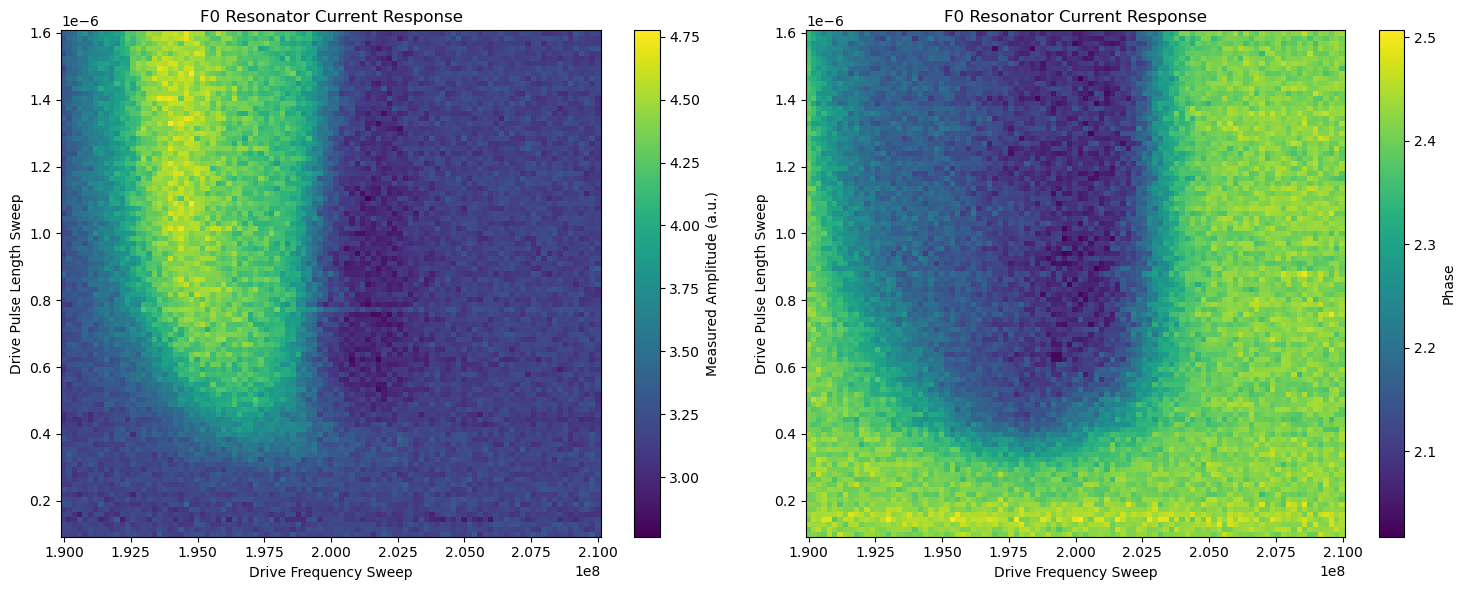

In [470]:
outer_sweep_param = my_acquired_results.axis[0]
inner_sweep_param = my_acquired_results.axis[1]
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.angle(IQ_data)

fig, ax = plt.subplots(1,2, figsize=(15,6))
cmap0 = ax[0].pcolor(inner_sweep_param,
    outer_sweep_param,
    amplitude,
    shading='nearest')
ax[0].set_title(f'{qubit.uid} Resonator Current Response')
ax[0].set_xlabel(f'{Inner_Sweep.uid}')
ax[0].set_ylabel(f'{Outer_Sweep.uid}')
cmap1 = ax[1].pcolor(inner_sweep_param,
    outer_sweep_param,
    phase,
    shading='nearest',)
cbar0 = fig.colorbar(cmap0, ax=ax[0],)
cbar1 = fig.colorbar(cmap1, ax=ax[1])
cbar0.set_label('Measured Amplitude (a.u.)')
cbar1.set_label('Phase')
ax[1].set_title(f'{qubit.uid} Resonator Current Response')
ax[1].set_xlabel(f'{Inner_Sweep.uid}')
ax[1].set_ylabel(f'{Outer_Sweep.uid}')
fig.tight_layout()

# Qubit T1

In [79]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=800e-6, count=15)

def T1_1shot():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
        ):
            with exp.section(uid='Play drive'):
                exp.play(
                    signal="drive",
                    pulse=pulse_library.gaussian_square(
                        uid=f"drive_spec_pulse_{qubit.uid}",
                        length=qubit.parameters.user_defined["pulse_length"],
                        amplitude=qubit.parameters.user_defined['amplitude_pi']), #1,) #max power to start
                )
                exp.delay('drive', time_delay)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    return exp

exp = T1_1shot()

## Compile Session
Do final checks before running the job.

In [7]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

NameError: name 'exp' is not defined

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [81]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters: [ 5.19871507e+03  1.73622025e-01 -6.77193658e-01]
T1 time 192.35522362412996 us


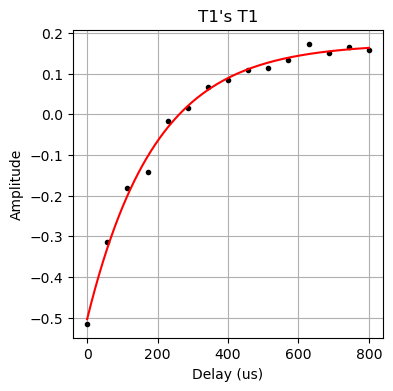

In [82]:
amplitude = np.abs(my_acquired_results.data)
phase = np.unwrap(np.angle(my_acquired_results.data))
phase = phase - np.mean(phase)

delay_plot = np.linspace(time_delay.start, time_delay.stop, 501)
popt, pcov = exponential_decay.fit(time_delay, phase, 1/40e-6, 10, 7, plot=False)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(time_delay*1e6, phase, '.k')
ax.plot(delay_plot*1e6, exponential_decay(delay_plot, *popt), '-r');
ax.set_title(f"{qubit.uid}'s T1")
ax.set_xlabel('Delay (us)')
ax.set_ylabel('Amplitude')
ax.grid()

print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

## T1 Statistics
Still need to change this to be of a matching format to the T2E and T2*

In [83]:
def T1_run():
    exp = T1_1shot()
    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    # psv.interactive_psv(compiled_session, max_events_to_publish=100,)
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

    IQ_data = my_acquired_results.data
    amplitude = np.abs(IQ_data)
    phase = np.unwrap(np.angle(IQ_data))
    phase = phase-np.mean(phase)
    
    try:
        popt_amp, pcov_amp = exponential_decay.fit(time_delay, amplitude, 1/40e-6, 10, 7, plot=False)
        print(f'Fitted Parameters (amplitude): {popt_amp}')
        print('T1 time ' + str(1/popt_amp[0]*1e6) + ' us')
        amp_t1 = popt_amp[0]
    except Exception as e:
        amp_t1 = None
    
    try:
        popt_phase, pcov_phase = exponential_decay.fit(time_delay, phase, 5e3, 0.2, -0.7, plot=False)
        print(f'Fitted Parameters (phase): {popt_phase}')
        print('T1 time ' + str(1/popt_phase[0]*1e6) + ' us')
        phase_t1 = popt_phase[0]
    except Exception as e: 
        phase_t1 = None
        
    return [amp_t1, phase_t1]

In [85]:
datetime_array, T1_data = measure_data_stats(T1_run, n_runs=1000)

[2024.11.27 09:03:26.681] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\analysis\fitting.py:77: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(func, x, y, p0=args, **kw)

Fitted Parameters (amplitude): [4.27395683e+05 3.26331344e+00 1.23315461e-01]
T1 time 2.339752224309503 us
Fitted Parameters (phase): [ 5.60154338e+03  1.59241989e-01 -6.59703563e-01]
T1 time 178.52222721384305 us
[2024.11.27 09:03:39.264] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\analysis\fitting.py:77: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = opt.curve_fit(func, x, y, p0=args, **kw)

Fitted Parameters (amplitude): [4.67745561e+05 3.25680296e+00 2.11814530e-01]
T1 time 2.137914464280018 us
Fitted Parameters (phase): [ 5.51847862e+03  1.69130462e-01 -6.92255815e-01]
T1 time 181.2093636981307 us
[2024.11.27 09:03:51.814] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\analysis\fitting.py:77: 

T1  =  187.38647204364085 +/- 21.237436650774974


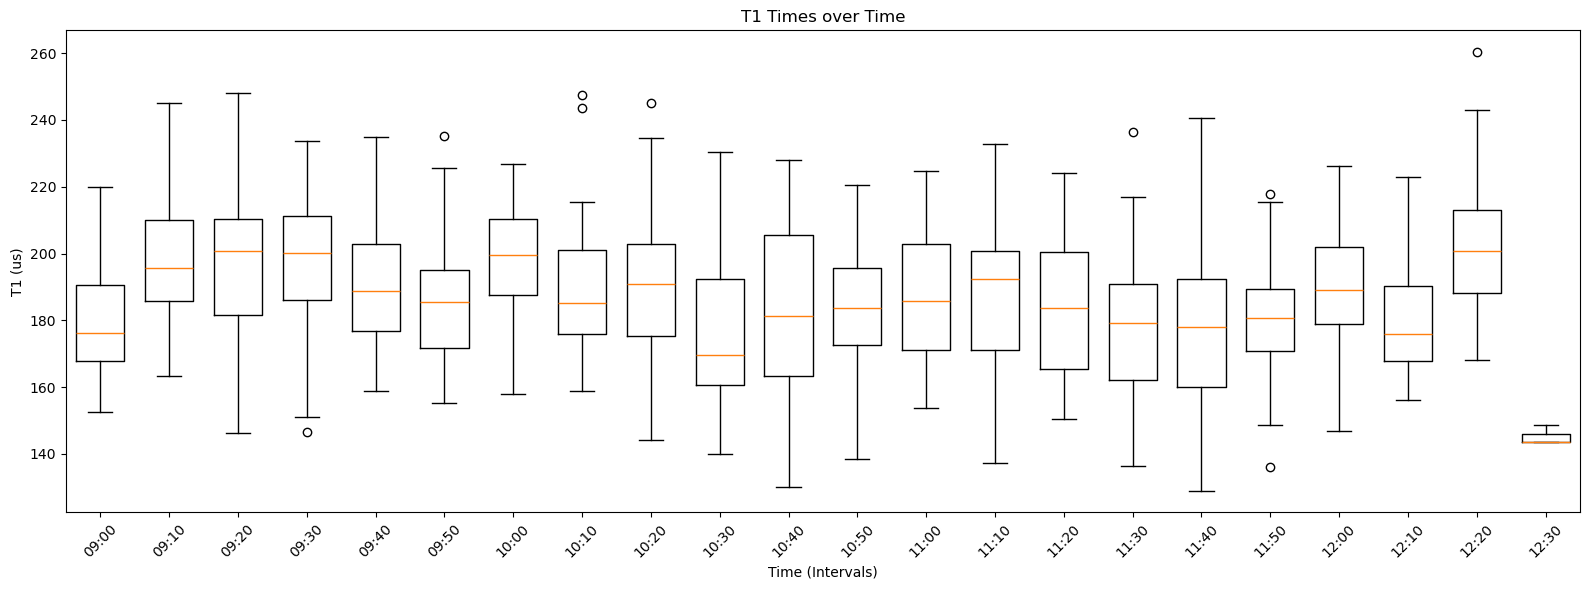

In [86]:
T1_plotted = T1_data[1,:]
stat_out(1/T1_plotted*1e6, 'T1')
plot_box_whisker_time_series(datetime_array, 1/T1_plotted*1e6, 'T1', time_interval_str='10min')

# Qubit T2*
Ramsey Measurement

In [23]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=60e-6, count=121)

ramsey_drive = pulse_library.gaussian_square(
    uid='ramsey_drive',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2'],
)

def T2star():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
        ):
            with exp.section(uid='Play drive'):
                exp.play(signal="drive", pulse=ramsey_drive)
                exp.delay('drive', time_delay)
                exp.play(signal="drive", pulse=ramsey_drive)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge+0.15e6, #offset here of about 1MHz to 3MHz to get precise frequency
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)

    return exp

exp = T2star()

## Compile Session
Do final checks before running the job.

In [8]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [165]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

Fitted parameters (amplitude): [ 2.16786210e+06 -2.08924897e+00  1.76758596e+04  4.99498555e-02
  3.15313522e+00]
detuning = 2.167862102339172 MHz, T2r = 56.57433484368432 us
Fitted parameters (phase): [ 2.32573087e+06 -4.97952852e+00  4.30852125e+04 -1.49203837e-01
 -7.39347578e-04]
detuning = 2.325730873658052 MHz, T2r = 23.20981938315447 us


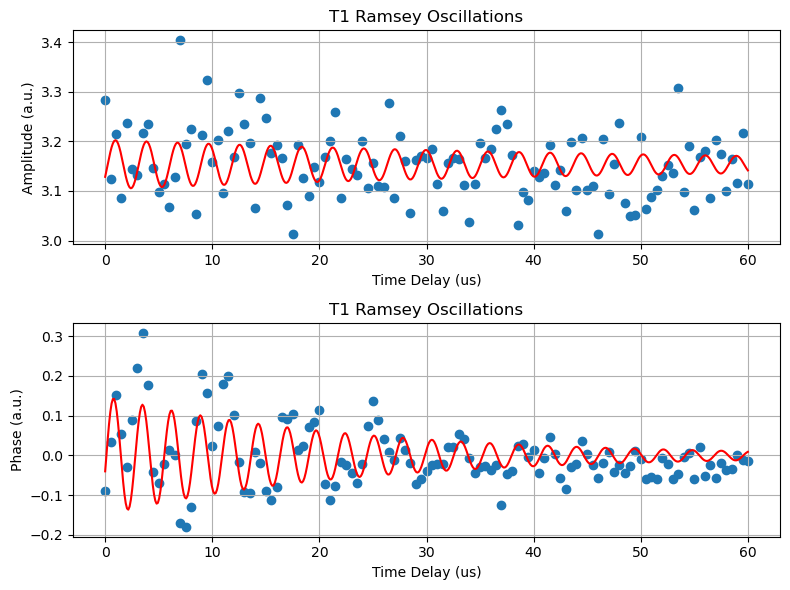

In [166]:
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.unwrap(np.angle(IQ_data))
phase = phase-np.mean(phase)

fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)

try: popt_amp, pcov_amp = oscillatory_decay.fit(time_delay, amplitude, 2e6, 0, 1e5, 0.1, 3)
except: pass

try: popt_phase, pcov_phase = oscillatory_decay.fit(time_delay, phase, 1e6, 0, 1e6, 0.5, 0) #frequency, phase, decay_rate, amplitude, offset
except: pass

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].scatter(time_delay*1e6, amplitude)
try: ax[0].plot(fitting_plot_x*1e6, oscillatory_decay(fitting_plot_x, *popt_amp), '-r')
except: pass
ax[0].set_title(f'{qubit.uid} Ramsey Oscillations')
ax[0].set_xlabel('Time Delay (us)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].grid()
ax[1].scatter(time_delay*1e6, phase)
try: ax[1].plot(fitting_plot_x*1e6, oscillatory_decay(fitting_plot_x, *popt_phase), '-r')
except: pass
ax[1].set_title(f'{qubit.uid} Ramsey Oscillations')
ax[1].set_xlabel('Time Delay (us)')
ax[1].set_ylabel('Phase (a.u.)')
ax[1].grid()
fig.tight_layout()
try:
    print(f"Fitted parameters (amplitude): {popt_amp}")
    print(f'detuning = {popt_amp[0]*1e-6} MHz, T2r = {1e6/popt_amp[2]} us')
except: pass
try:
    print(f"Fitted parameters (phase): {popt_phase}")
    print(f'detuning = {popt_phase[0]*1e-6} MHz, T2r = {1e6/popt_phase[2]} us')
except: pass

## Ramsey Statistics

In [24]:
def T2star_run():
    exp = T2star()
    
    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name
    
    IQ_data = my_acquired_results.data
    amplitude = np.abs(IQ_data)
    phase = np.unwrap(np.angle(IQ_data))
    phase = phase-np.mean(phase)
    
    try:
        popt_amp, pcov_amp = oscillatory_decay.fit(time_delay, amplitude, 2e6, 0, 1e5, 0.1, 3)
        print(f'Fitted Parameters (amplitude): {popt_amp}')
        print('T2* time ' + str(1/popt_amp[2]*1e6) + ' us')
        amp_t2star = np.abs(popt_amp[2])
    except Exception as e:
        amp_t2star = None
    
    try:
        popt_phase, pcov_phase = oscillatory_decay.fit(time_delay, phase, 2.0e6, 1, 3e4, 0.2, 0, plot=False) #frequency, phase, decay_rate, amplitude, offset
        print(f'Fitted Parameters (phase): {popt_phase}')
        print('T2* time ' + str(1/popt_phase[2]*1e6) + ' us')
        phase_t2star = np.abs(popt_phase[2])
    except: 
        phase_t2star = None
        
    return [amp_t2star, phase_t2star]

In [25]:
datetime_array, T2star_data = measure_data_stats(T2star_run, n_runs=1000)

Fitted Parameters (amplitude): [ 1.76085990e+06 -5.93884574e-01  1.48692928e+04  3.63277991e-02
  3.17019658e+00]
T2* time 67.25269415844701 us
Fitted Parameters (phase): [ 1.88279775e+06  5.11200398e+00 -1.94731938e+04 -4.06016960e-03
 -5.07886913e-05]
T2* time -51.352644683960754 us
Fitted Parameters (amplitude): [ 1.58740944e+06  1.34152288e+01 -1.41047359e+04  1.60060353e-02
  3.15684185e+00]
T2* time -70.89817258307181 us
Fitted Parameters (phase): [ 2.13951228e+06 -4.13432624e+00 -4.18271333e+04  2.22975511e-03
  1.90266393e-04]
T2* time -23.907925812040975 us
Fitted Parameters (amplitude): [1.82181480e+06 3.91015442e-02 2.66699107e+04 7.57776806e-02
 3.16962588e+00]
T2* time 37.49543860680687 us
Fitted Parameters (phase): [ 2.61404789e+06 -1.66624479e+00  4.16829082e+04  1.58513371e-01
 -7.03734594e-04]
T2* time 23.9906485178834 us
Fitted Parameters (amplitude): [ 2.05887037e+06 -4.80508485e-01  1.10684469e+04  2.89425014e-02
  3.17349587e+00]
T2* time 90.34691256819175 us
Fitte

In [49]:
boolean_filt = (T2star_data[1,:] > 1e4)
T2star_data_filtered = np.copy(T2star_data)
T2star_data_filtered[1,:] = np.where(boolean_filt, T2star_data[1,:], None) 
print(1/T2star_data_filtered[1,:40]*1e6)

[51.35264468 23.90792581 23.99064852 24.42792097 44.39735353 26.41142794
 25.75129136 19.81080339 15.47061057 18.23760012 20.26074724 48.79217157
 20.78693332 22.77607378 17.89211921 47.07498078 20.30509495 22.2114612
 51.97013662 19.73926355 16.44951986 18.94580137 13.4694674  18.64432707
 17.95649596  8.15256986 13.43718645 11.48681239 16.42286288  9.70685431
 13.12161949 18.35924086 16.42555475 21.46329918 21.23132512 19.51960311
 15.35746546 24.11016133 18.68936294 24.61566006]


T2*  =  28.332367101681157 +/- 12.894629241728483


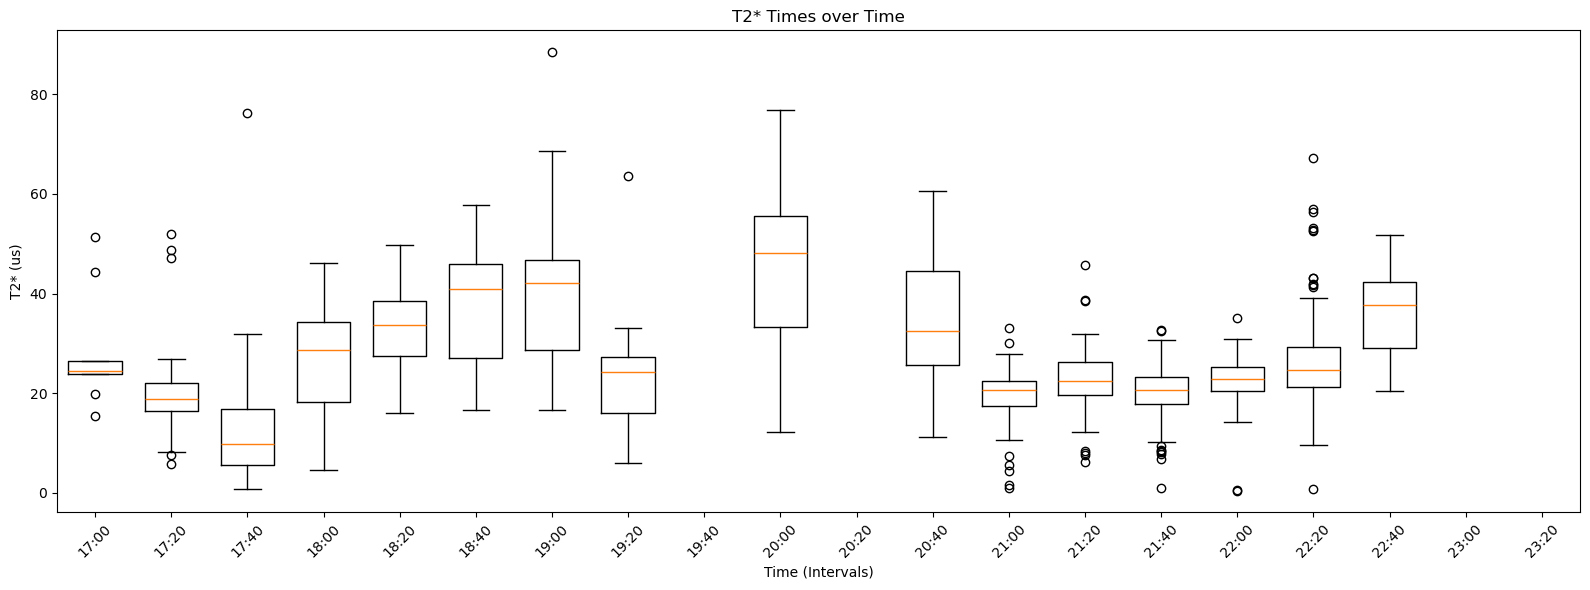

In [50]:
T2star_plotted = T2star_data_filtered[1,:]
stat_out(1/T2star_plotted*1e6, 'T2*')
plot_box_whisker_time_series(datetime_array, 1/T2star_plotted*1e6, 'T2*', time_interval_str='20min')

# T2 Echo

In [31]:
time_delay = LinearSweepParameter(
    uid='time_delay', start=0, stop=150e-6, count=16)

x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

y180 = pulse_library.gaussian_square(
    uid='y180',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi']
)

def T2Echo():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        reset_oscillator_phase=True
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
            alignment=SectionAlignment.RIGHT,
            reset_oscillator_phase=True
        ):
            with exp.section(uid='Play drive', alignment=SectionAlignment.RIGHT):
                exp.play(signal="drive", phase=0, pulse=x90)
                exp.delay('drive', time_delay/2)
                exp.play(signal="drive", phase=np.pi, pulse=y180)
                exp.delay('drive', time_delay/2)
                exp.play(signal='drive', phase=0, pulse=x90)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( 
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge,
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)

    return exp
    
exp = T2Echo()x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

y180 = pulse_library.gaussian_square(
    uid='y180',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi']
)

def T2Echo():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        reset_oscillator_phase=True
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
            alignment=SectionAlignment.RIGHT,
            reset_oscillator_phase=True
        ):
            with exp.section(uid='Play drive', alignment=SectionAlignment.RIGHT):
                exp.play(signal="drive", phase=0, pulse=x90)
                exp.delay('drive', time_delay/2)
                exp.play(signal="drive", phase=np.pi, pulse=y180)
                exp.delay('drive', time_delay/2)
                exp.play(signal='drive', phase=0, pulse=x90)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( 
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge,
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)

    return exp
    
exp = T2Echo()x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

y180 = pulse_library.gaussian_square(
    uid='y180',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi']
)

def T2Echo():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
        ]
    )
    
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        reset_oscillator_phase=True
    ):
        with exp.sweep(
            uid='Delay_sweep',
            parameter=time_delay,
            alignment=SectionAlignment.RIGHT,
            reset_oscillator_phase=True
        ):
            with exp.section(uid='Play drive', alignment=SectionAlignment.RIGHT):
                exp.play(signal="drive", phase=0, pulse=x90)
                exp.delay('drive', time_delay/2)
                exp.play(signal="drive", phase=np.pi, pulse=y180)
                exp.delay('drive', time_delay/2)
                exp.play(signal='drive', phase=0, pulse=x90)
            with exp.section(
                uid="single_res_point_readout",
                play_after='Play drive',
            ):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse)
                exp.acquire( 
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                    kernel=readout_pulse
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
                exp.reserve(signal="measure")
                exp.reserve(signal="drive")
    
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge,
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,)
    exp.set_calibration(exp_calibration)

    return exp
    
exp = T2Echo()

## Compile Session
Do final checks before running the job.

In [32]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
# psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [322]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

## Plot and Analyze Data

[2024.11.26 14:16:49.580] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\dsl\parameter.py:85: RuntimeWarning: overflow encountered in exp
  values = ufunc(*new_inputs)

Fitted parameters (amplitude): [6.43980863e+04 2.90981595e+00 1.78775379e-01]
T2e time 15.528411743818323 us
Fitted parameters (phase): [ 2.49107238e+04 -9.27365887e-02  3.33373860e-01]
T2e time 40.14335385644942 us


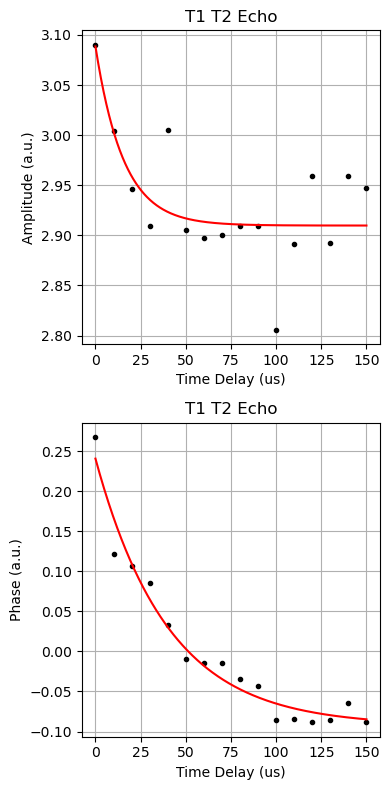

In [324]:
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.unwrap(np.angle(IQ_data))
phase = phase-np.mean(phase)

fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)

try: popt_amp, pcov_amp = exponential_decay.fit(time_delay, amplitude, 1e6, 0 , 1)
except: pass

try: popt_phase, pcov_phase = exponential_decay.fit(time_delay, phase, 1e6, 0, 1) #decay rate, offset, amplitude
except: pass

fig, ax = plt.subplots(2, 1, figsize=(4,8))
ax[0].plot(time_delay*1e6, amplitude, '.k')
try: ax[0].plot(fitting_plot_x*1e6, exponential_decay(fitting_plot_x, *popt_amp), '-r')
except: pass
ax[0].set_title(f'{qubit.uid} T2 Echo')
ax[0].set_xlabel('Time Delay (us)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].grid()
ax[1].plot(time_delay*1e6, phase, '.k')
try: ax[1].plot(fitting_plot_x*1e6, exponential_decay(fitting_plot_x, *popt_phase), '-r')
except: pass
ax[1].set_title(f'{qubit.uid} T2 Echo')
ax[1].set_xlabel('Time Delay (us)')
ax[1].set_ylabel('Phase (a.u.)')
ax[1].grid()
fig.tight_layout()
try:
    print(f"Fitted parameters (amplitude): {popt_amp}")
    print('T2e time ' + str(1/popt_amp[0]*1e6) + ' us') 
except: pass
try:
    print(f"Fitted parameters (phase): {popt_phase}")
    print('T2e time ' + str(1/popt_phase[0]*1e6) + ' us') 
except: pass

Fitted parameters (amplitude): [5.00776089e+04 2.86842114e+00 2.04095308e-01]
T2e time 19.96900455375843 us
Fitted parameters (phase): [ 3.25152399e+04 -5.66631871e-02  3.58824104e-01]
T2e time 30.75480923583845 us


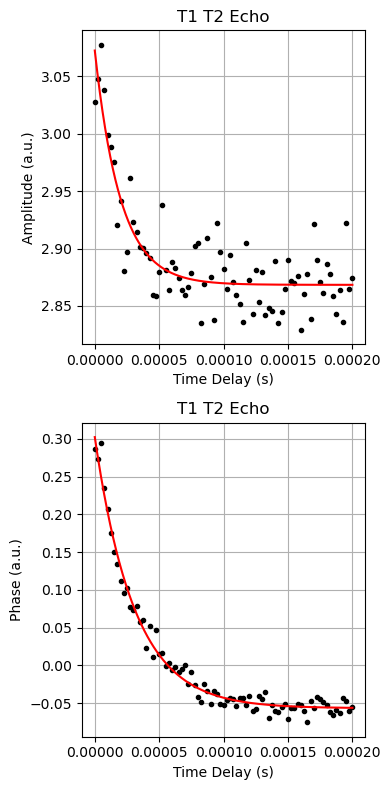

In [303]:
IQ_data = my_acquired_results.data
amplitude = np.abs(IQ_data)
phase = np.unwrap(np.angle(IQ_data))
phase = phase-np.mean(phase)

fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)

try: popt_amp, pcov_amp = exponential_decay.fit(time_delay, amplitude, 1e6, 0 , 1)
except: pass

try: popt_phase, pcov_phase = exponential_decay.fit(time_delay, phase, 1e6, 0, 1) #decay rate, offset, amplitude
except: pass

fig, ax = plt.subplots(2, 1, figsize=(4,8))
ax[0].plot(time_delay, amplitude, '.k')
try: ax[0].plot(fitting_plot_x, exponential_decay(fitting_plot_x, *popt_amp), '-r')
except: pass
ax[0].set_title(f'{qubit.uid} T2 Echo')
ax[0].set_xlabel('Time Delay (s)')
ax[0].set_ylabel('Amplitude (a.u.)')
ax[0].grid()
ax[1].plot(time_delay, phase, '.k')
try: ax[1].plot(fitting_plot_x, exponential_decay(fitting_plot_x, *popt_phase), '-r')
except: pass
ax[1].set_title(f'{qubit.uid} T2 Echo')
ax[1].set_xlabel('Time Delay (s)')
ax[1].set_ylabel('Phase (a.u.)')
ax[1].grid()
fig.tight_layout()
try:
    print(f"Fitted parameters (amplitude): {popt_amp}")
    print('T2e time ' + str(1/popt_amp[0]*1e6) + ' us') 
except: pass
try:
    print(f"Fitted parameters (phase): {popt_phase}")
    print('T2e time ' + str(1/popt_phase[0]*1e6) + ' us') 
except: pass

## T2E Statistics

In [34]:
def T2E_run():
    exp = T2Echo()
    session = Session(
        device_setup=device_setup,
        log_level = logging.WARNING,
        experiment=exp)
    session.connect();
    compiled_session = session.compile(exp);
    
    results = session.run()
    my_results = session.get_results() #a deep copy of session.results
    my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name
    
    IQ_data = my_acquired_results.data
    amplitude = np.abs(IQ_data)
    phase = np.unwrap(np.angle(IQ_data))
    phase = phase-np.mean(phase)
    
    fitting_plot_x = np.linspace(time_delay.start, time_delay.stop, 501)
    
    try:
        popt_amp, pcov_amp = exponential_decay.fit(time_delay, amplitude, 1e6, 0 , 1)
        print(f"Fitted Parameters (amplitude): {popt_amp}")
        print('T2e time ' + str(1/popt_amp[0]*1e6) + ' us')
        amp_t2e = popt_amp[0]
    except Exception as e:
        amp_t2e = None
    try:
        popt_phase, pcov_phase = exponential_decay.fit(time_delay, phase, 1e6, 0, 1) #decay rate, offset, amplitude
        print(f"Fitted Parameters (phase): {popt_phase}")
        print('T2e time ' + str(1/popt_phase[0]*1e6) + ' us')
        phase_t2e = popt_phase[0]
    except Exception as e: 
        phase_t2e = None
        
    return [amp_t2e, phase_t2e]

In [37]:
datetime_array, T2E_data = measure_data_stats(T2E_run, n_runs=300)

[2024.11.26 15:07:26.501] WARNING Stop conditions still not fulfilled after 15.000000 s, estimated execution time was 12.41 s. Continuing to the next step.
Not fulfilled:
SHFQC/QA:dev12195: Generator 1 didn't stop. Missing start trigger? Check ZSync.
SHFQC/SG:dev12195: AWG 4 didn't stop. Missing start trigger? Check ZSync.
[2024.11.26 15:07:31.529] ERROR   SHFQC/QA:dev12195:ch0:readout0: Failed to receive all results within 5 s, timing out.


[2024.11.26 15:07:31.529] ERROR   SHFQC/QA:dev12195:ch0:readout0: Failed to receive all results within 5 s, timing out.


[2024.11.26 15:07:31.529] ERROR   SHFQC/QA:dev12195:ch0:readout0: Results for job id(s) {0} are missing.


[2024.11.26 15:07:31.529] ERROR   SHFQC/QA:dev12195:ch0:readout0: Results for job id(s) {0} are missing.


[2024.11.26 15:07:49.023] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\dsl\parameter.py:85: RuntimeWarning: overflow encountered in exp
  values = ufunc(*new_inputs)

Fitted Parameters (amplitude): [7.92225986e+03 2.97775649e+00 1.41707129e-01]
T2e time 126.22660921531606 us
Fitted Parameters (phase): [ 2.37709860e+04 -1.08590724e-01  3.75972786e-01]
T2e time 42.068090841887646 us
[2024.11.26 15:08:03.040] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\dsl\parameter.py:85: RuntimeWarning: overflow encountered in exp
  values = ufunc(*new_inputs)

Fitted Parameters (amplitude): [4.12140538e+04 3.01401680e+00 1.22102007e-01]
T2e time 24.26356805913455 us
Fitted Parameters (phase): [ 2.22861030e+04 -1.18933055e-01  3.91217299e-01]
T2e time 44.87101224391093 us
[2024.11.26 15:08:17.135] WARNING C:\Users\QNL\anaconda3\Lib\site-packages\laboneq\dsl\parameter.py:85: RuntimeWarning: overflow encountered in exp
  values = ufunc(*new_inputs)

Fitted Parameters (amplitude): 

T2E  =  47.08549162946611 +/- 9.010110312081967


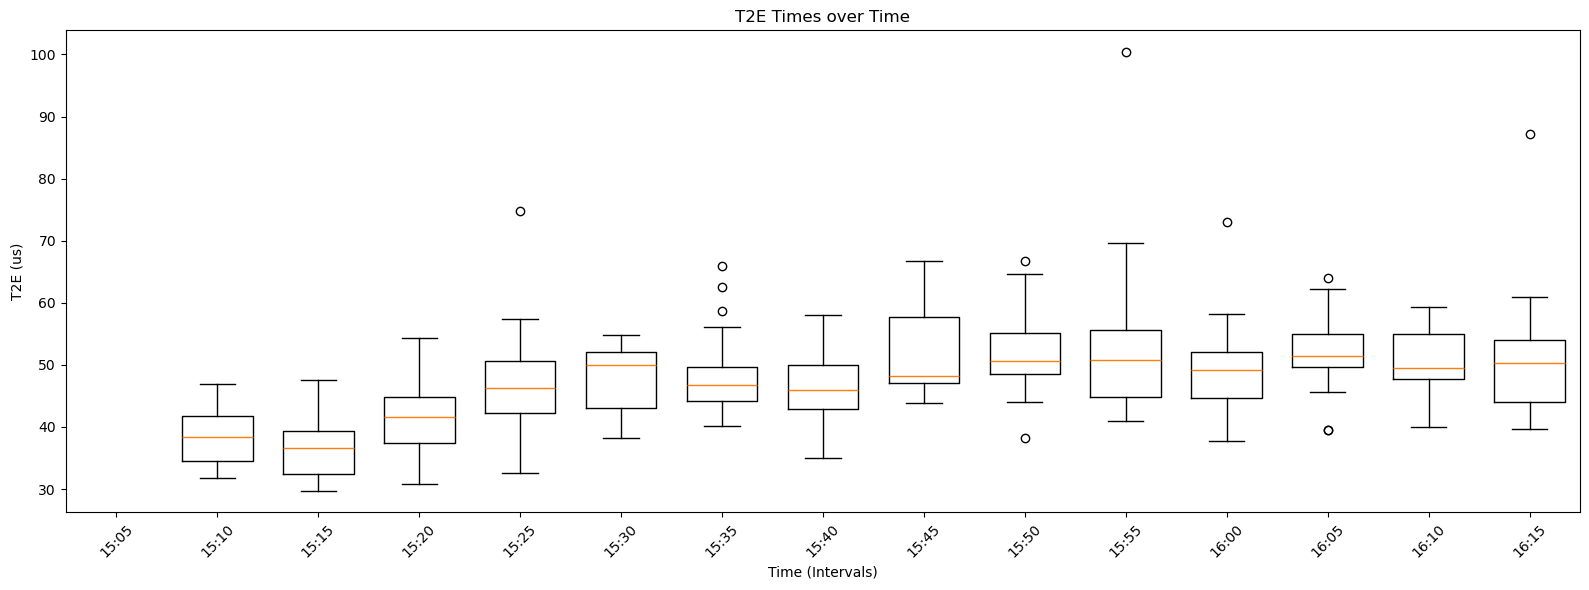

In [41]:
T2E_plotted = T2E_data[1,:]
stat_out(1/T2E_plotted*1e6, 'T2E')
plot_box_whisker_time_series(datetime_array, 1/T2E_plotted*1e6, 'T2E', time_interval_str='5min')

# Qubit 1D Flux Spectrum (WIP)

# Qubit 2D Flux Spectrum (WIP)

# Fast Flux Pulse

In [ ]:
fast_flux_array = np.asarray([[0.5,0],[1,0],[0.5,0]])
fast_flux_pulse = pulse_library.sampled_pulse(samples=fast_flux_array, uid='Fast_Flux_Pulse')
print(fast_flux_array.shape) #first column is I data, second is Q (and the Q appears as neg of entered value. If phase doesn't matter, just do I)
fast_flux_pulse

In [143]:
def create_arbitrary_pulse(fname: str, uid: str) -> laboneq.dsl.experiment.pulse.PulseSampled:
    '''Takes in a .csv file and outputs a pulse that has the same shape as the csv file sample-wise (typ. 0.5ns).
    
    This should be a two column array from -1 to 1 for each column, specifying the pulse shape.
    First column is for I values, second is for Q. Note Q intensity on pulse sheet will have additional negative sign.
    '''
    array = np.loadtxt(fname, delimeter=',')
    pulse = pulse_library.sampled_pulse(samples=array, uid=uid)
    return pulse

In [140]:
delay_time=2e-9 #this is the time after the start of the flux pulse at which the drive line starts playing

x90 = pulse_library.gaussian_square(
    uid='x90',
    length=qubit.parameters.user_defined['pulse_length'],
    amplitude=qubit.parameters.user_defined['amplitude_pi/2']
)

def fast_flux_pulse_exp():
    exp = Experiment(
        uid="Spectroscopy",
        signals=[
            ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
            ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
            ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line']),
            ExperimentSignal(uid="flux", map_to=lsg[qubit.uid]['flux_drive_line'])
        ]
    )
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        reset_oscillator_phase=False
    ):
        with exp.section(uid='Fast Flux Pulse',):
            exp.play(signal='flux', pulse=fast_flux_pulse)
            exp.delay(signal='drive', time=delay_time)
            exp.play(signal='drive', pulse=x90)
        with exp.section(uid="single_res_point_readout", play_after='Fast Flux Pulse'):
            exp.play(signal="measure", pulse=readout_pulse)
            exp.acquire(signal='acquire', handle='single_freq_data', length=qubit.parameters.user_defined['readout_len'], kernel=readout_pulse)
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['time_domain_reset_length']):
            exp.reserve('measure')
            exp.reserve('acquire')
            exp.reserve('drive')
            exp.reserve('flux')
    exp_calibration = Calibration()
    drive_osc = Oscillator(
        "drive_osc",
        frequency=qubit.parameters.drive_frequency_ge,
        modulation_type=ModulationType.HARDWARE)
    drive_lo = Oscillator(
        'drive_lo',
        frequency=qubit.parameters.drive_lo_frequency,
        modulation_type=ModulationType.HARDWARE)
    exp_calibration["drive"] = SignalCalibration(
        oscillator=drive_osc,
        local_oscillator=drive_lo,)
    exp_calibration["flux"] = SignalCalibration(
        local_oscillator=drive_lo, #CAUTION! This only shares an LO with the drive line because the two channels literally share an LO
        port_mode=PortMode.LF)
    exp.set_calibration(exp_calibration)
    return exp
    
exp = fast_flux_pulse_exp()

## Compile Session
Do final checks before running the job.

In [141]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect();
compiled_session = session.compile(exp);
psv.interactive_psv(compiled_session, max_events_to_publish=100,)

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [131]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

In [ ]:
def data_directory_update():
    '''Updates data directory to today's date'''
    date = datetime.date.today()
    datadir = Path('data/' + str(date) + '/')
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    return datadir
    
datadir = data_directory_update() # might as well instantly update for the rest of the notebook

def non_redund_save_fig(fig, name):
    '''A function to prevent figure overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        fig_name = Path(str(datadir) + f'/{name}_{i}.png')
        if os.path.isfile(fig_name) is False:
            fig_name = Path(str(datadir) + f'/{name}_{i}')
            fig.savefig(fig_name)
            break
        else:
            i = i+1

def non_redund_save_pd(pd_data, name):
    '''A function to prevent pd overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(pd_name) is False:
            pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
            pd_data.to_csv(pd_name)
            break
        else:
            i += 1

def non_redund_save_csv(csv_data, name):
    '''A function to prevent csv overwrite issues'''
    datadir = data_directory_update()
    i = 1
    while True:
        csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(csv_name) is False:
            csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
            csv_data.to_csv(csv_name)
            break
        else:
            i += 1